**Program melatih model menggunakan VGG16**

In [1]:
# Import library yang dibutuhkan
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import splitfolders

In [2]:
# Path direktori data latihan dan validasi
input_dir = 'C:/Users/RAIHAN FAIZ/Documents/Skripsi/Penelitian/Dataset/CK+48/dataset/'
output_dir = 'C:/Users/RAIHAN FAIZ/Documents/Skripsi/Penelitian/Dataset/CK+48/split/'
split_ratio = (0.6, 0.2, 0.2)  # Rasio pembagian train, val, test

# Split folder
splitfolders.ratio(input_dir, output=output_dir, seed=42, ratio=split_ratio)

Copying files: 981 files [00:10, 91.77 files/s] 


In [3]:
# Path direktori data train, validasi, dan test
train_dir = output_dir + 'train'
val_dir = output_dir + 'val'
test_dir = output_dir + 'test'

In [4]:
# Parameter model dan pelatihan
input_shape = (48, 48, 3)
num_classes = 7
batch_size = 64
epochs = 100

In [5]:
# Membuat generator data latihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True  # Tambahkan pergeseran vertikal
)

# Membuat generator data validasi dan test tanpa augmentasi
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Muat dan augmentasi data latihan
train_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode='rgb',  # Ubah color_mode menjadi 'rgb'
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)

# Muat data validasi
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    color_mode='rgb',  # Ubah color_mode menjadi 'rgb'
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)

# Muat data test
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    color_mode='rgb',  # Ubah color_mode menjadi 'rgb'
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 783 images belonging to 7 classes.
Found 290 images belonging to 7 classes.
Found 201 images belonging to 7 classes.


In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

# Membangun model VGG
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [8]:
# Kompilasi model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Callback untuk menghentikan pelatihan jika akurasi mencapai target
class MyCallback(keras.callbacks.Callback):
    def __init__(self, target_accuracy):
        super(MyCallback, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is not None and val_accuracy >= self.target_accuracy:
            print(f"\nValidation accuracy reached {self.target_accuracy}. Training stopped.")
            self.model.stop_training = True

# Set target accuracy yang diinginkan
target_accuracy = 0.9
callbacks = [MyCallback(target_accuracy)]

In [10]:
# Latih model menggunakan generator data dan callback
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=callbacks
)

Epoch 1/100
12/12 [==============================] - 31s 2s/step - loss: 1.8598 - accuracy: 0.2712 - val_loss: 1.6848 - val_accuracy: 0.4766
Epoch 2/100
12/12 [==============================] - 26s 2s/step - loss: 1.6003 - accuracy: 0.4312 - val_loss: 1.3500 - val_accuracy: 0.5195
Epoch 3/100
12/12 [==============================] - 26s 2s/step - loss: 1.4587 - accuracy: 0.4465 - val_loss: 1.4976 - val_accuracy: 0.4609
Epoch 4/100
12/12 [==============================] - 25s 2s/step - loss: 1.4080 - accuracy: 0.5076 - val_loss: 1.0338 - val_accuracy: 0.6953
Epoch 5/100
12/12 [==============================] - 25s 2s/step - loss: 1.0955 - accuracy: 0.6106 - val_loss: 0.8136 - val_accuracy: 0.7422
Epoch 6/100
12/12 [==============================] - 25s 2s/step - loss: 0.9718 - accuracy: 0.6467 - val_loss: 0.6390 - val_accuracy: 0.7734
Epoch 7/100
12/12 [==============================] - 25s 2s/step - loss: 0.8238 - accuracy: 0.6954 - val_loss: 0.6319 - val_accuracy: 0.7969
Epoch 8/100
1

In [11]:
# Simpan model dengan metadata label
model.save('emotion_model_vgg16.h5')

**Menguji Model dengan Data Uji yang disiapkan**

In [12]:
import random
import os

test_samples_dir = 'C:/Users/RAIHAN FAIZ/Documents/Skripsi/Penelitian/Dataset/CK+48/split/test'
class_names = sorted(os.listdir(test_samples_dir))

# Memilih 5 sampel acak dari setiap kelas emosi
random_samples = {}
for class_name in class_names:
    class_dir = os.path.join(test_samples_dir, class_name)
    sample_files = os.listdir(class_dir)
    random_samples[class_name] = random.sample(sample_files, 5)

In [13]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Fungsi untuk menguji model pada satu sampel gambar
def predict_emotion(model, image_path):
    image = load_img(image_path, color_mode='rgb', target_size=(48, 48))
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    result = model.predict(image_array)
    return result[0]

# Proses pengujian
for class_name, samples in random_samples.items():
    print(f"\nEmosi: {class_name}")
    for sample_file in samples:
        sample_path = os.path.join(test_samples_dir, class_name, sample_file)
        result = predict_emotion(model, sample_path)
        predicted_class = class_names[np.argmax(result)]
        print(f"Gambar: {sample_file} => Prediksi: {predicted_class}, Skor: {result.max():.4f}")



Emosi: anger
1/1 [==============================] - 0s 318ms/step
Gambar: S011_004_00000019.png => Prediksi: anger, Skor: 0.8147
1/1 [==============================] - 0s 47ms/step
Gambar: S045_005_00000030.png => Prediksi: anger, Skor: 0.6584
1/1 [==============================] - 0s 56ms/step
Gambar: S503_001_00000069.png => Prediksi: anger, Skor: 0.6838
1/1 [==============================] - 0s 78ms/step
Gambar: S032_003_00000016.png => Prediksi: anger, Skor: 0.9393
1/1 [==============================] - 0s 47ms/step
Gambar: S100_005_00000023.png => Prediksi: anger, Skor: 0.9256

Emosi: disgust
1/1 [==============================] - 0s 48ms/step
Gambar: S068_005_00000021.png => Prediksi: disgust, Skor: 0.9911
1/1 [==============================] - 0s 48ms/step
Gambar: S057_003_00000014.png => Prediksi: disgust, Skor: 0.9759
1/1 [==============================] - 0s 32ms/step
Gambar: S116_006_00000005.png => Prediksi: disgust, Skor: 0.9974
1/1 [==============================] - 0s 4

**Plot Akurasi dan Loss, Classification Report, dan Confusion Matrix**

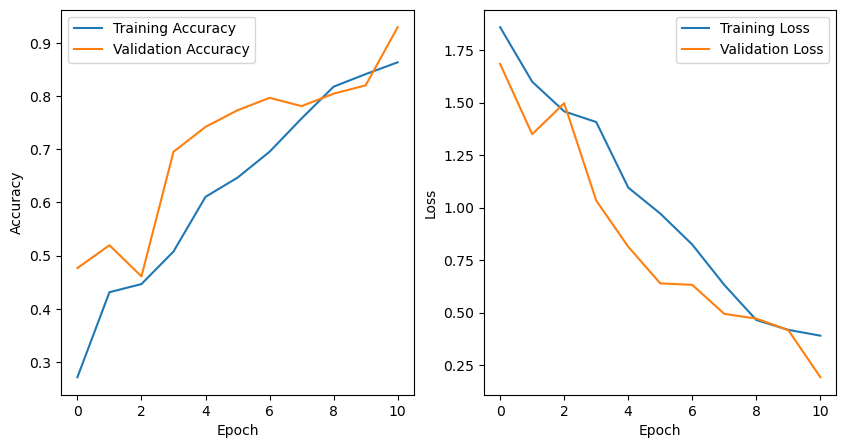

In [14]:
# Plot akurasi dan loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Evaluasi model pada data test
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

4/4 [==============================] - 1s 356ms/step - loss: 0.2212 - accuracy: 0.9055
Test Loss: 0.22122342884540558
Test Accuracy: 0.9054726362228394


In [16]:
# Prediksi menggunakan model
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

4/4 [==============================] - 1s 226ms/step


In [17]:
# Classification report
target_names = list(test_generator.class_indices.keys())
classification_rep = classification_report(y_true, y_pred_classes, target_names=target_names)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

       anger       0.76      0.96      0.85        27
     disgust       1.00      1.00      1.00        36
        fear       0.90      0.60      0.72        15
       happy       0.91      1.00      0.95        42
     nuetral       0.83      0.83      0.83        12
         sad       0.90      0.50      0.64        18
    surprise       0.94      0.98      0.96        51

    accuracy                           0.91       201
   macro avg       0.89      0.84      0.85       201
weighted avg       0.91      0.91      0.90       201



In [18]:
# Confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(confusion_mtx)

Confusion Matrix:
[[26  0  0  0  0  1  0]
 [ 0 36  0  0  0  0  0]
 [ 0  0  9  2  2  0  2]
 [ 0  0  0 42  0  0  0]
 [ 0  0  0  2 10  0  0]
 [ 8  0  0  0  0  9  1]
 [ 0  0  1  0  0  0 50]]


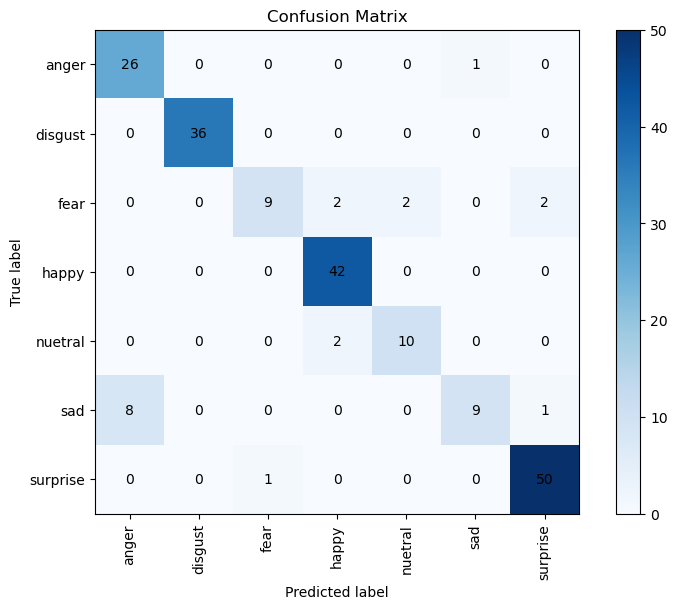

In [19]:
# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Menambahkan angka pada matriks
for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        plt.text(j, i, str(confusion_mtx[i, j]), color='black', horizontalalignment='center', verticalalignment='center')

plt.show()